In [1]:
import os
import time
import shutil
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils as utils
import torch.nn.init as init
from torchvision import datasets

In [2]:
data_type = 'mfcc'
model_num = 2
time_len =  0.5  ## ms
if time_len==0.5:
    point_len = 25
else:
    point_len = int(45000*time_len/1000)
div_num = int(450*(200/point_len))
vow_num = int(div_num/5)

point_len = 20
fc_len = int(point_len/32)+1

In [3]:
class Model(nn.Module):
    def __init__(self, loss):
        super(Model, self).__init__()
        prob = 0.8
        input_c = 1
        channel = 32
        self.conv1 = nn.Sequential(
            nn.Conv1d(input_c, channel, kernel_size=5, stride=2, padding=2),
#             nn.Dropout(p=prob),
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm1d(channel))
        self.conv2 = nn.Sequential(
            nn.Conv1d(channel, channel*2, kernel_size=5, stride=2, padding=2),
#             nn.Dropout(p=prob),
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm1d(channel*2))
        self.conv3 = nn.Sequential(
            nn.Conv1d(channel*2, channel*2, kernel_size=5, stride=2, padding=2),
#             nn.Dropout(p=prob),
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm1d(channel*2))
        self.conv4 = nn.Sequential(
            nn.Conv1d(channel*2, channel*4, kernel_size=5, stride=2, padding=2),
#             nn.Dropout(p=prob),
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm1d(channel*4))
        self.conv5 = nn.Sequential(
            nn.Conv1d(channel*4, channel*4, kernel_size=5, stride=2, padding=2),
#             nn.Dropout(p=prob),
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm1d(channel*4))
        self.fc1 = nn.Sequential(
            nn.Linear(channel*4*fc_len, 1024),
#             nn.Dropout(p=prob),
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm1d(1024))
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 5),
            nn.Softmax(dim=1))
        self.loss = loss
        
    def forward(self, data, target):
        x = self.conv1(data)
#         print('1',x.size())
        x = self.conv2(x)
#         print('2',x.size())
        x = self.conv3(x)
#         print('3',x.size())
        x = self.conv4(x)
#         print('4',x.size())
        x = self.conv5(x)
#         print('5',x.size())
        x = x.view(x.size()[0],-1)
        x = self.fc1(x)
#         print('8',x.size())
        h = self.fc2(x)
#         print('9',h.size())
        
        l = self.loss(h, target)
        return l, h, target

In [4]:
def train(model, trainX, trainY, batch, device, optimizer, train_loss, train_acc):
    model.train()
    dloss = 0
    dacc = 0
    
    rand = torch.randperm(trainX.size()[0])
    trainX = trainX[rand]
    trainY = trainY[rand]
    
    for i in range(batch[0]):
        optimizer.zero_grad()
        loss, output, target = model(trainX[i*batch[1]:(i+1)*batch[1]], trainY[i*batch[1]:(i+1)*batch[1]])
        loss = loss.sum()
        loss.backward()
        optimizer.step()
        
        _, output = torch.max(output, 1)
        _, target = torch.max(target, 1)

        dloss += loss.cpu().item()
        dacc += (output==target).sum().item()
        
    train_loss.append(dloss/batch[0])
    train_acc.append(dacc/(batch[0]*batch[1]))
    return train_loss, train_acc

def test(model, testX, testY, device, test_loss, test_acc):
    model.eval()
    loss, output, target = model(testX, testY)
    loss = loss.sum()
    
    _, output = torch.max(output, 1)
    _, target = torch.max(target, 1)
    
    test_loss.append(loss.cpu().item())
    test_acc.append((output==target).sum().item()/len(testX))
    return test_loss, test_acc, output, target

In [5]:
if __name__=='__main__':    
    print('[Training]%s_%.1f_model%d'%(data_type, time_len, model_num))
    torch.manual_seed(37)
    torch.cuda.manual_seed_all(37)
    torch.backends.cudnn.deterministic = True
    
    trainX = np.load('npy_data/%s/%s_%.1fms_trainX.npy'%(data_type, data_type, time_len)).reshape(-1, 1, point_len)
    trainY = np.load('npy_data/%s/%s_%.1fms_trainY.npy'%(data_type, data_type, time_len))
    testX = np.load('npy_data/%s/%s_%.1fms_testX.npy'%(data_type, data_type, time_len)).reshape(-1, 1, point_len)
    testY = np.load('npy_data/%s/%s_%.1fms_testY.npy'%(data_type, data_type, time_len))

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    batch_num = 1000
    batch = [int(len(trainX)/batch_num), batch_num]
    
    trainX = torch.Tensor(trainX).to(device)
    trainY = torch.Tensor(trainY).to(device)
    testX = torch.Tensor(testX).to(device)
    testY = torch.Tensor(testY).to(device)
    print('%s data shape  -  %.1f ms'%(data_type, time_len))
    print('train set :', np.shape(trainX) , np.shape(trainY))
    print('test set :', np.shape(testX) ,np.shape(testY))
    
    
    learning_rate = 0.00005
    loss_func=nn.BCELoss()
    model = nn.DataParallel(Model(loss_func)).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=batch_num, eta_min = 3e-6)

    model.load_state_dict(torch.load('ckpt/model%d/%s/%.1f_ckpt_1000.pt'%(model_num, data_type, time_len)))
    a = time.time()
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    for epoch in range(1):
        train_loss, train_acc = train(model, trainX, trainY, batch, device, optimizer, train_loss, train_acc)
        test_loss, test_acc, output, target = test(model, testX, testY, device, test_loss, test_acc)
        scheduler.step()
        
        if epoch%10==0: 
            vowel_check = (output==target).cpu().detach().numpy()
            vowel_acc = np.zeros(5)
            for k1 in range(15):
                for k2 in range(5):
                    vowel_acc[k2] += np.sum(vowel_check[div_num*k1 + vow_num*k2 : div_num*k1 + vow_num*(k2+1)])
            print(vowel_acc/(vow_num*15))
            print('epoch %d - train loss : %.7f  /  test loss : %.7f'%(epoch, train_loss[-1], test_loss[-1]))
            print('           train acc : %.7f  /  test acc : %.7f'%(train_acc[-1], test_acc[-1]))
#         if epoch%50==0:
#             print('@@@@@@@ save model : epoch %d'% epoch)
#             torch.save(model.state_dict(),'ckpt/model%d_%s/%.1f_ckpt_%d.pt'%(model_num, data_type, time_len, epoch))
#             np.savetxt('result/model%d_%s/%.1f_loss_tr.txt'%(model_num, data_type, time_len), train_loss)
#             np.savetxt('result/model%d_%s/%.1f_loss_te.txt'%(model_num, data_type, time_len), test_loss)
#             np.savetxt('result/model%d_%s/%.1f_acc_tr.txt'%(model_num, data_type, time_len), train_acc)
#             np.savetxt('result/model%d_%s/%.1f_acc_te.txt'%(model_num, data_type, time_len), test_acc)
    print("training complete! - calculation time :", time.time()-a, '  seconds')

[Training]mfcc_0.5_model2
mfcc data shape  -  0.5 ms
train set : torch.Size([180000, 1, 20]) torch.Size([180000, 5])
test set : torch.Size([54000, 1, 20]) torch.Size([54000, 5])


/opt/anaconda3/envs/khj/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


[0.56287037 0.29898148 0.59759259 0.49564815 0.23157407]
epoch 0 - train loss : 0.6213193  /  test loss : 1.0078001
           train acc : 0.6206944  /  test acc : 0.4373333
training complete! - calculation time : 3.601633310317993   seconds


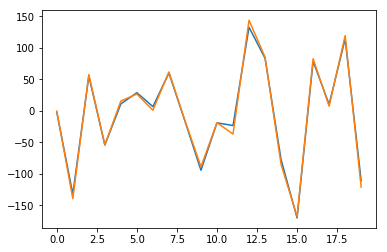

tensor([[0.0389, 0.1482, 0.6381, 0.0307, 0.1442]], device='cuda:0',
       grad_fn=<GatherBackward>)
tensor([[0.0171, 0.2886, 0.1480, 0.0194, 0.5269]], device='cuda:0',
       grad_fn=<GatherBackward>)
desired :  2         4
predict :  0         4


In [27]:
num_1 = 100
num_2 = 50000
sample_data1 = trainX[num_1].view(1,1,-1)
sample_label1 = trainY[num_1].view(1,-1)
sample_data2 = trainX[num_2].view(1,1,-1)
sample_label2 = trainY[num_2].view(1,-1)
plt.plot(sample_data1[0][0].cpu().detach().numpy())
plt.plot(sample_data2[0][0].cpu().detach().numpy())
plt.show()

_, output1, label1 = model(sample_data1, sample_label1)
_, output2, label2 = model(sample_data2, sample_label2)
print(output1)
print(output2)
print('desired : ', np.argmax(output1.cpu().detach().numpy()),'       ', np.argmax(output2.cpu().detach().numpy()))
print('predict : ', np.argmax(sample_label1.cpu().detach().numpy()),'       ', np.argmax(sample_label2.cpu().detach().numpy()))

In [6]:
vowel_check = (output==target).cpu().detach().numpy()
vowel_acc = np.zeros(5)
for k1 in range(15):
    for k2 in range(5):
        vowel_acc[k2] += np.sum(vowel_check[div_num*k1 + vow_num*k2 : div_num*k1 + vow_num*(k2+1)])
print('whole accuracy :', vowel_acc/(vow_num*15))
            
vowel_check = (output==target).cpu().detach().numpy()
whole_count=np.array([])
for k1 in range(15):
    for k2 in range(5):
        if k2==4:
            aa = output[div_num*k1 + vow_num*k2 : div_num*k1 + vow_num*(k2+1)].cpu().detach().numpy()+1
#             print(aa)
            bb = aa*((-1*np.int32(vowel_check[div_num*k1 + vow_num*k2 : div_num*k1 + vow_num*(k2+1)]))+1)
            whole_count = np.append(whole_count,bb)
unique, counts = np.unique(whole_count, return_counts=True)
#         vowel_acc[k2] += np.sum(vowel_check[div_num*k1 + vow_num*k2 : div_num*k1 + vow_num*(k2+1)])
print('\npart accuracy \n', dict(zip(unique, counts/(len(output)/5))))

whole accuracy : [0.56287037 0.29898148 0.59759259 0.49564815 0.23157407]

part accuracy 
 {0.0: 0.23157407407407407, 1.0: 0.09712962962962964, 2.0: 0.12407407407407407, 3.0: 0.24981481481481482, 4.0: 0.2974074074074074}
